<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session5_normalization/Session_5_Assignment_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Code


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import random

### Data transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(fill=(0,),degrees=(-7,7)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

##### Dataset and creating test and train data

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Visualizing the dataset

### Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1
dropout_value = 0

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model

In [5]:
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model as net

Saving model.py to model (3).py


### Model parameters

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           1,728
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 18, 24, 24]             432
             ReLU-10           [-1, 18, 24, 24]               0
        MaxPool2d-11           [-1, 18, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,592

# Displaying misclassified images

In [7]:
def test_missclassified(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = F.nll_loss(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
    return true,pred,image,true_wrong,pred_wrong

In [8]:
# show misclassified images
def wrong_plot(n_figures,true,ima,pred, norm):
    print ("Normalization technique: ", norm)
    #n_row = int(n_figures/3)
    plt.figure(figsize = (20, 10))
    for r in range(n_figures):
      a = random.randint(0,len(true)-1)  
      image,correct,wrong = ima[a],true[a],pred[a]
      img_tensor = torch.from_numpy(image).unsqueeze(0).to(device)
      image = torch.from_numpy(image).squeeze()
      #correct = int(correct)
      #wrong = int(wrong)
      f = 'Actual:'+str(int(correct)) + ',' +'Predicted:'+str(int(wrong))
      image = image.numpy()
      
      plt.subplot(2,5,r+1)    # the number of images in the grid is 5*5 (25)
      im = plt.imshow(image)
      plt.title(f)
    plt.show()

### Training and testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, l_val, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 normalization
    if l_val > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + l_val*l1
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model (step size = 6)

---



In [10]:
def run_model(model, device, train_loader, test_loader, l_val):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  EPOCHS = 20

  for epoch in range (EPOCHS):
     print("EPOCH:", epoch+1)
     train(model, device, train_loader, optimizer, l_val, train_losses, train_acc)
     test(model, device, test_loader, test_losses, test_acc)  

  return train_losses, train_acc, test_losses, test_acc

Normalization type:  Batch
EPOCH: 1


Loss=1.7376294136047363 Batch_id=468 Accuracy=87.01: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]



Test set: Average loss: 0.3512, Accuracy: 9201/10000 (92.01%)

EPOCH: 2


Loss=1.1846988201141357 Batch_id=468 Accuracy=93.91: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]



Test set: Average loss: 0.4447, Accuracy: 8804/10000 (88.04%)

EPOCH: 3


Loss=1.1424916982650757 Batch_id=468 Accuracy=93.84: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]



Test set: Average loss: 0.4292, Accuracy: 8763/10000 (87.63%)

EPOCH: 4


Loss=1.1825860738754272 Batch_id=468 Accuracy=93.90: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.5798, Accuracy: 8200/10000 (82.00%)

EPOCH: 5


Loss=1.1617584228515625 Batch_id=468 Accuracy=94.08: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]



Test set: Average loss: 1.1325, Accuracy: 6323/10000 (63.23%)

EPOCH: 6


Loss=1.0708072185516357 Batch_id=468 Accuracy=93.86: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]



Test set: Average loss: 0.6206, Accuracy: 7941/10000 (79.41%)

EPOCH: 7


Loss=1.0336333513259888 Batch_id=468 Accuracy=93.93: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]



Test set: Average loss: 0.7056, Accuracy: 7680/10000 (76.80%)

EPOCH: 8


Loss=1.0728093385696411 Batch_id=468 Accuracy=94.07: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]



Test set: Average loss: 0.2792, Accuracy: 9155/10000 (91.55%)

EPOCH: 9


Loss=1.042957067489624 Batch_id=468 Accuracy=93.99: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]



Test set: Average loss: 0.7171, Accuracy: 7494/10000 (74.94%)

EPOCH: 10


Loss=1.0687706470489502 Batch_id=468 Accuracy=94.16: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.3964, Accuracy: 8780/10000 (87.80%)

EPOCH: 11


Loss=1.0275614261627197 Batch_id=468 Accuracy=94.16: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 1.0550, Accuracy: 6653/10000 (66.53%)

EPOCH: 12


Loss=1.2016479969024658 Batch_id=468 Accuracy=94.11: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 1.2751, Accuracy: 7046/10000 (70.46%)

EPOCH: 13


Loss=1.0567071437835693 Batch_id=468 Accuracy=94.03: 100%|██████████| 469/469 [00:18<00:00, 24.74it/s]



Test set: Average loss: 1.6399, Accuracy: 5598/10000 (55.98%)

EPOCH: 14


Loss=1.036518931388855 Batch_id=468 Accuracy=94.14: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.6130, Accuracy: 8053/10000 (80.53%)

EPOCH: 15


Loss=1.0937613248825073 Batch_id=468 Accuracy=94.11: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]



Test set: Average loss: 0.3803, Accuracy: 8769/10000 (87.69%)

EPOCH: 16


Loss=1.0344483852386475 Batch_id=468 Accuracy=94.09: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.7880, Accuracy: 7583/10000 (75.83%)

EPOCH: 17


Loss=1.0913581848144531 Batch_id=468 Accuracy=93.99: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]



Test set: Average loss: 2.0243, Accuracy: 4749/10000 (47.49%)

EPOCH: 18


Loss=1.1599698066711426 Batch_id=468 Accuracy=94.10: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.8440, Accuracy: 6975/10000 (69.75%)

EPOCH: 19


Loss=1.1450982093811035 Batch_id=468 Accuracy=94.06: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.3744, Accuracy: 8808/10000 (88.08%)

EPOCH: 20


Loss=1.1290045976638794 Batch_id=468 Accuracy=94.19: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]



Test set: Average loss: 0.5000, Accuracy: 8261/10000 (82.61%)

Normalization technique:  Batch


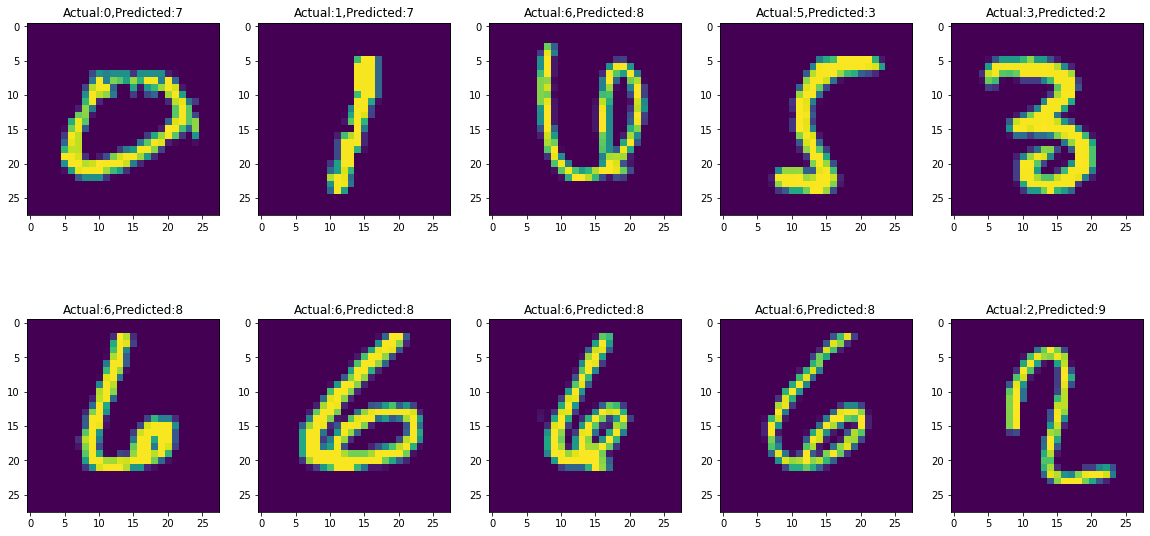




Normalization type:  Layer
EPOCH: 1


Loss=0.11012867838144302 Batch_id=468 Accuracy=86.97: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.1001, Accuracy: 9765/10000 (97.65%)

EPOCH: 2


Loss=0.0302544217556715 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]



Test set: Average loss: 0.0582, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.043854985386133194 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0481, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Loss=0.05045107379555702 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]



Test set: Average loss: 0.0440, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.026093261316418648 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0440, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Loss=0.05642521381378174 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]



Test set: Average loss: 0.0351, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.05507954955101013 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]



Test set: Average loss: 0.0309, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.01550381537526846 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0305, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.027449384331703186 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]



Test set: Average loss: 0.0286, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.04620733484625816 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.02170572243630886 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.009343059733510017 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]



Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.03538719192147255 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.002714959904551506 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.003976352978497744 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0316, Accuracy: 9900/10000 (99.00%)

EPOCH: 16


Loss=0.004307374823838472 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]



Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.01158761978149414 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]



Test set: Average loss: 0.0234, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.015502401627600193 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.01756438799202442 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 20


Loss=0.004149310756474733 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]



Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

Normalization technique:  Layer


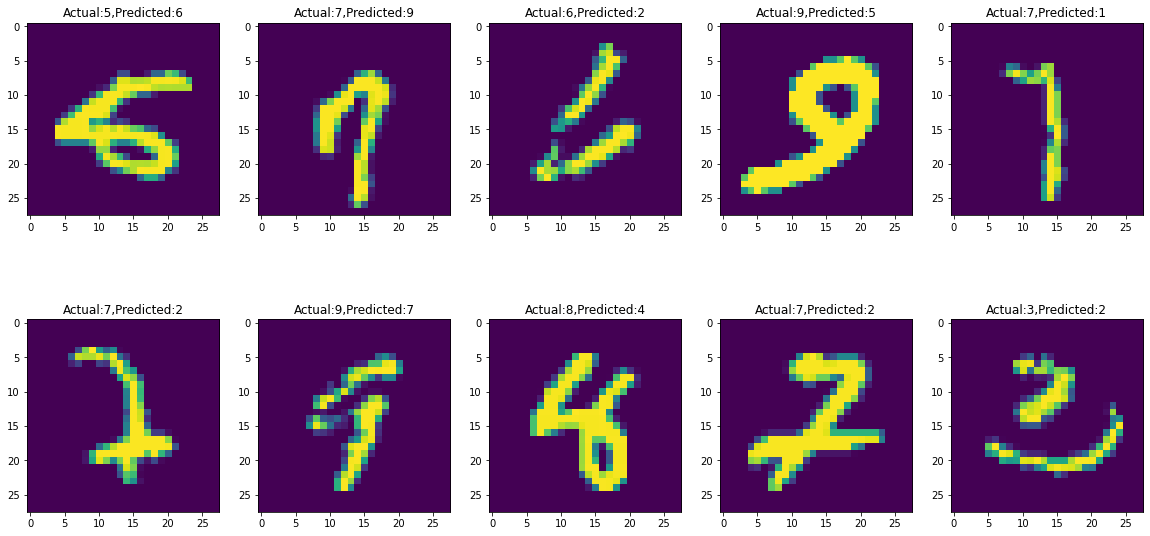




Normalization type:  Group
EPOCH: 1


Loss=0.05734395608305931 Batch_id=468 Accuracy=84.36: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.1081, Accuracy: 9741/10000 (97.41%)

EPOCH: 2


Loss=0.056471530348062515 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0550, Accuracy: 9855/10000 (98.55%)

EPOCH: 3


Loss=0.04532063007354736 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0534, Accuracy: 9838/10000 (98.38%)

EPOCH: 4


Loss=0.024988850578665733 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]



Test set: Average loss: 0.0400, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.0281582772731781 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0349, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.05054387450218201 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]



Test set: Average loss: 0.0336, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.03732845559716225 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]



Test set: Average loss: 0.0306, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.023863933980464935 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0279, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.031259190291166306 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]



Test set: Average loss: 0.0265, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.06440427154302597 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0298, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.03686492517590523 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]



Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.009396928362548351 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]



Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.032235290855169296 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.005712923128157854 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.005341913551092148 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0224, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.007129515055567026 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]



Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.00453838799148798 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.005044681951403618 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.027605382725596428 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.04338594153523445 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]



Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

Normalization technique:  Group


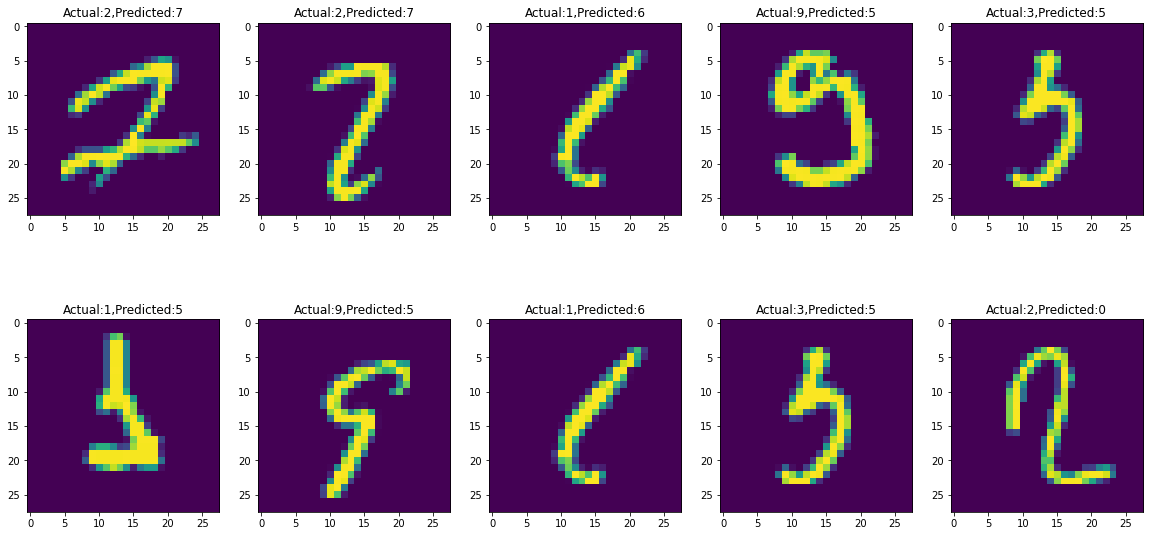

In [11]:
normalization_iter = ["Batch", "Layer", "Group"]
num_of_groups_iter = [0, 0, 8]
lambda_val = [0.01, 0, 0]

train_losses_all=[]
train_acc_all=[]
test_losses_all=[]
test_acc_all=[]

for (norm, no_gps, l_val) in zip(normalization_iter, num_of_groups_iter, lambda_val):
  print ("Normalization type: ", norm)
  model =  net.Net(normalization_type=norm, group_num = no_gps).to(device) 
  train_losses, train_acc, test_losses, test_acc = run_model(model, device, train_loader, test_loader, l_val)
  train_losses_all.append(train_losses)
  train_acc_all.append(train_acc)
  test_losses_all.append(test_losses)
  test_acc_all.append(test_acc)
  true,pred,image,true_wrong,pred_wrong = test_missclassified(test_loader)
  wrong_plot(10,true_wrong,image,pred_wrong, norm)
  print ("\n\n")

### Plotting

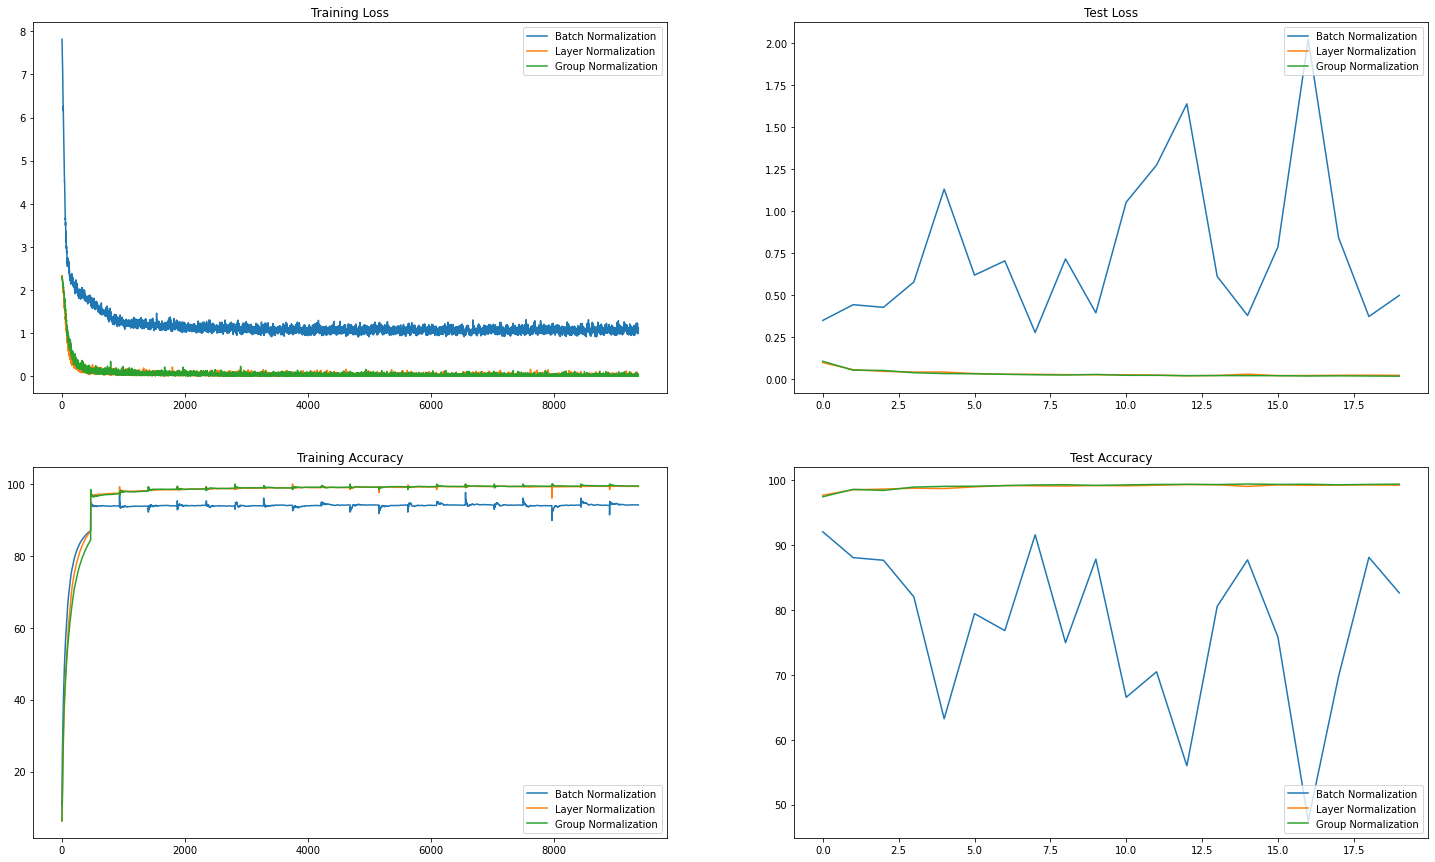

In [12]:
fig, axs = plt.subplots(2,2,figsize=(25,15))
for i, norm_type in enumerate(normalization_iter):

      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses_all[i], label = norm_type + " Normalization")
      axs[0,0].legend(loc='upper right')
  

      axs[1, 0].plot(train_acc_all[i], label = norm_type + " Normalization")
      axs[1,0].legend(loc='lower right')


      axs[0, 1].plot(test_losses_all[i], label = norm_type + " Normalization")
      axs[0,1].legend(loc='upper right')


      axs[1, 1].plot(test_acc_all[i], label = norm_type + " Normalization")
      axs[1,1].legend(loc='lower right')